In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Recommendation Data + User Info**



In [ ]:
import pandas as pd
rec=pd.read_csv('/content/drive/MyDrive/good_NCF_version2.csv')

In [ ]:
rec.head()

,user_id,test_item,rank,hit_status,final_top10,candidate_size
0,1,1566,295,Miss,"[17, 357, 2396, 1704, 2858, 356, 902, 25, 838,...",761
1,2,1917,33,Miss,"[2716, 1580, 608, 1, 527, 1208, 1377, 912, 150...",731
2,5,1485,230,Miss,"[527, 1673, 2396, 3160, 2336, 3481, 3897, 1639...",730
3,6,597,5,Hit,"[357, 356, 1704, 539, 597, 2671, 902, 1961, 17...",758
4,8,1,34,Miss,"[3578, 3408, 2959, 2997, 3897, 3160, 223, 2706...",729


In [ ]:
import ast

# 문자열 형태의 리스트를 실제 리스트로 변환
rec['final_top10'] = rec['final_top10'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [ ]:
print(type(rec['final_top10'].iloc[0]))
# 리스트로 잘 있는지 확인

<class 'list'>


## **Data for Clustering**


In [ ]:
rec.shape

(4430, 6)

## **Jaccard 유사도를 활용**
- 추천 리스트가 서로 얼마나 겹치는지(집합 유사도)를 기준으로 클러스터링
- J(A,B)=
∣A∪B∣
∣A∩B∣
​

↪ 두 사용자 A와 B의 추천 리스트에서 겹치는 영화 비율이 높을수록 유사도가 높음

↪ 이때의 단점은 사용자의 추천 리스트 순위는 반영이 안된다는 것..!

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

# Jaccard 거리 행렬 계산
recommendation_lists = rec['final_top10'].apply(set).tolist()
jaccard_distance_matrix = pairwise_distances(recommendation_lists, metric=lambda x, y: 1 - len(x & y) / len(x | y))

In [ ]:
# 각 사용자별 추천 리스트 기반 distance matrix
jaccard_distance_matrix.shape

(4430, 4430)

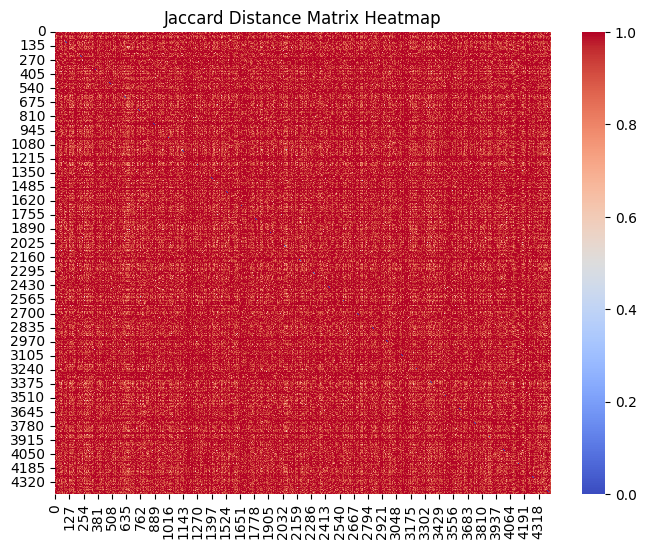

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(jaccard_distance_matrix, cmap="coolwarm", annot=False)
plt.title("Jaccard Distance Matrix Heatmap")
plt.show()

In [ ]:
jaccard_distance_matrix[0,0]

0.0

## **시각화 위한 패키지 깔기**

In [ ]:
!pip install umap-learn

In [ ]:
import umap

# UMAP 변환 (Jaccard Distance Matrix 사용)
umap_model = umap.UMAP(n_components=2, metric="precomputed", random_state=42)
umap_data = umap_model.fit_transform(jaccard_distance_matrix)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE 변환 (2D)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_data = tsne.fit_transform(jaccard_distance_matrix)

In [ ]:
from sklearn.manifold import trustworthiness

# Trustworthiness Score 계산
score = trustworthiness(jaccard_distance_matrix, tsne_data, n_neighbors=5)
print(f"t-SNE Trustworthiness Score: {score:.4f}")

t-SNE Trustworthiness Score: 0.9815


In [ ]:
# UMAP 변환 (Jaccard Distance Matrix 사용)
umap_model = umap.UMAP(n_components=2, metric="precomputed", random_state=42)
umap_data = umap_model.fit_transform(jaccard_distance_matrix)

In [ ]:
from sklearn.manifold import trustworthiness

# Trustworthiness Score 계산
score = trustworthiness(jaccard_distance_matrix, umap_data, n_neighbors=5)
print(f"UMAP Trustworthiness Score: {score:.4f}")

UMAP Trustworthiness Score: 0.8462


[결론]
- jaccard matrix를 가장 2차원으로 잘 설명하는 건 tsne이 이 시각화를 중점적으로 봐야할 것

# ⭐**최종 알고리즘**

## **SpectralClustering**

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
from sklearn.cluster import SpectralClustering

sim_matrix = 1 - jaccard_distance_matrix

# 스펙트럴 군집
spectral = SpectralClustering(
    n_clusters=5,
    affinity='precomputed',
    random_state=42
)
labels_spectral = spectral.fit_predict(sim_matrix)

In [ ]:
silhouette_score(jaccard_distance_matrix, labels_spectral, metric="precomputed")
# 러프하게 한번 확인해보기

0.02752921043799786

### **최적의 K 값 찾기**

k=2, Silhouette=0.0286
k=3, Silhouette=0.0295
k=4, Silhouette=0.0292
k=5, Silhouette=0.0275
k=6, Silhouette=0.0266
k=7, Silhouette=0.0280
k=8, Silhouette=0.0271
k=9, Silhouette=0.0263
k=10, Silhouette=0.0255


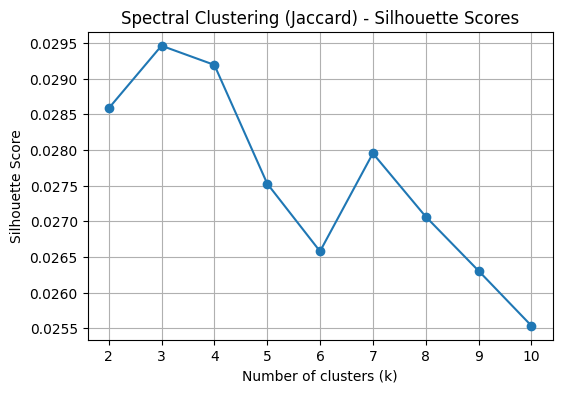

In [ ]:
k_values = range(2, 11)  # 2 ~ 10
sil_scores = []

for k in k_values:
    # 4) Spectral Clustering (유사도행렬 사용)
    spectral = SpectralClustering(
        n_clusters=k,
        affinity='precomputed',
        random_state=42
    )
    labels_spectral = spectral.fit_predict(sim_matrix)

    # 5) 실루엣 스코어 계산 (거리행렬 사용, metric='precomputed')
    score = silhouette_score(jaccard_distance_matrix, labels_spectral, metric='precomputed')
    sil_scores.append(score)
    print(f"k={k}, Silhouette={score:.4f}")

# 6) 결과 시각화
plt.figure(figsize=(6, 4))
plt.plot(k_values, sil_scores, marker='o')
plt.title("Spectral Clustering (Jaccard) - Silhouette Scores")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.grid(True)
plt.show()

가장 실루엣 스코어가 높은건 3일 때지만, 너무 데이터가 작아질 수 있으니 number of cluster를 4로 설정 (+ 실루엣 스코어 하도 낮아서 부질없다..)

In [ ]:
spectral = SpectralClustering(n_clusters=4,affinity='precomputed',random_state=42)
labels_spectral = spectral.fit_predict(sim_matrix)

### **PCA로 시각화 하기**

In [ ]:
from sklearn.decomposition import PCA

# Jaccard 거리 행렬을 2D로 축소
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(jaccard_distance_matrix)

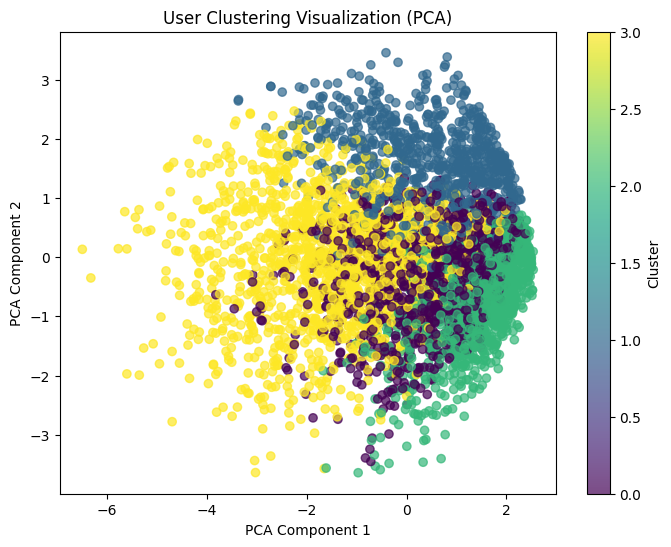

In [ ]:
# 클러스터링 결과 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels_spectral, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("User Clustering Visualization (PCA)")
plt.show()

In [ ]:
 np.sum(pca.explained_variance_ratio_)

0.2801927066502074

In [ ]:
representative=[4110, 1874,  252, 2064]

### **UMAP으로 시각화 하기 + 대표값 넣어서**

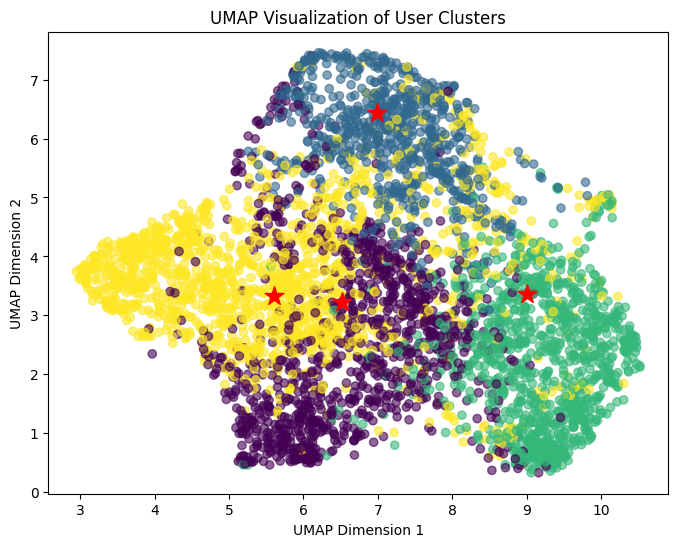

In [ ]:
# UMAP 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(umap_data[:, 0],umap_data[:, 1],c=labels_spectral, alpha=0.6)
plt.scatter(umap_data[representative, 0], umap_data[representative, 1],
            color='red', marker='*', s=200, label="Cluster Representatives")
plt.title("UMAP Visualization of User Clusters")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

### **TSNE로 시각화하기 + 대표값 넣어서**

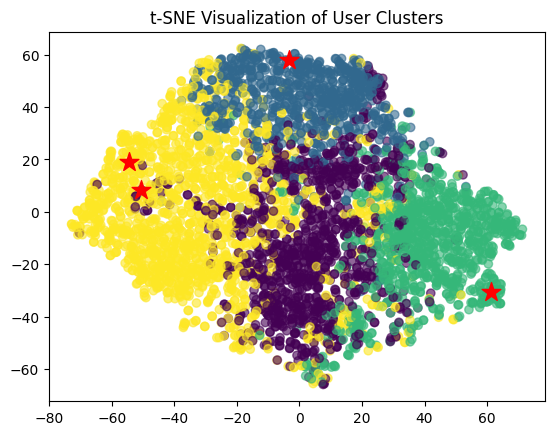

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 시각화
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], alpha=0.6, c=labels_spectral)
plt.scatter(tsne_data[representative, 0], tsne_data[representative, 1],
            color='red', marker='*', s=200, label="Cluster Representatives")
plt.title("t-SNE Visualization of User Clusters")
plt.show()

## **결정 ! -> 각 클러스터 중심값 찾기**

In [ ]:
rec['label']=labels_spectral

In [ ]:
rec['label'].value_counts()

,count
label,
3,1559
0,1089
2,1026
1,756


### **원 핫 인코딩**

In [ ]:
# 고유한 영화 ID 추출
unique_items = sorted(set.union(*rec['final_top10'].apply(set)))
item_to_index = {item: idx for idx, item in enumerate(unique_items)}

# 각 사용자의 추천 리스트를 One-hot Encoding으로 변환
def encode_list(lst):
    encoded = np.zeros(len(unique_items))
    for item in lst:
        encoded[item_to_index[item]] = 1
    return encoded

# DataFrame으로 변환 (컬럼명을 영화 ID로 설정)
X = pd.DataFrame(
    [encode_list(lst) for lst in rec['final_top10']],
    columns=unique_items
)

In [ ]:
X.shape

(4430, 510)

In [ ]:
rec

,user_id,test_item,rank,hit_status,final_top10,candidate_size,label
0,1,1566,295,Miss,"[17, 357, 2396, 1704, 2858, 356, 902, 25, 838,...",761,0
1,2,1917,33,Miss,"[2716, 1580, 608, 1, 527, 1208, 1377, 912, 150...",731,3
2,5,1485,230,Miss,"[527, 1673, 2396, 3160, 2336, 3481, 3897, 1639...",730,3
3,6,597,5,Hit,"[357, 356, 1704, 539, 597, 2671, 902, 1961, 17...",758,0
4,8,1,34,Miss,"[3578, 3408, 2959, 2997, 3897, 3160, 223, 2706...",729,3
...,...,...,...,...,...,...,...
4425,6035,153,11,Miss,"[2858, 588, 2028, 587, 1676, 2997, 736, 1917, ...",682,3
4426,6036,1882,93,Miss,"[1704, 2291, 2333, 2858, 1747, 3578, 356, 1230...",562,3
4427,6037,2527,30,Miss,"[1204, 3435, 1084, 920, 1256, 1199, 1260, 951,...",692,1
4428,6039,912,5,Hit,"[910, 905, 920, 1307, 912, 902, 928, 2186, 356...",732,1


### **원핫인코딩된 데이터 + 각 label 별로 코사인 유사도가 가장 높은 행을 대표값으로 선정**

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

# 클러스터 개수
n_clusters = 4
representative_indices = []
# 각 클러스터에서 대표 샘플 찾기
for i in range(n_clusters):
    cluster_points = X[X['label'] == i].drop(columns=['label'])  # 클러스터 내 데이터 (label 제외)

    # 코사인 유사도 행렬 계산 (행 간 유사도 측정)
    similarity_matrix = cosine_similarity(cluster_points)

    # 각 행별 평균 유사도 계산 (다른 모든 행과 얼마나 비슷한지)
    avg_similarity = similarity_matrix.mean(axis=1)

    # 평균 유사도가 가장 높은 (즉, 클러스터 내에서 가장 대표적인) 행의 인덱스 찾기
    representative_idx = X[X['label'] == i].index[np.argmax(avg_similarity)]

    # 대표 인덱스 리스트에 추가
    representative_indices.append(representative_idx)

# 대표 인덱스를 DataFrame으로 변환
representative_df = pd.DataFrame({'Cluster': range(n_clusters), 'Representative_Index': representative_indices})

In [ ]:
representative_df

,Cluster,Representative_Index
0,0,4110
1,1,1874
2,2,252
3,3,2064


In [ ]:
representative_df['Representative_Index'].values

array([4110, 1874,  252, 2064])

In [ ]:
representative_df.T

,0,1,2,3
0,1280,4065,1590,2086


In [ ]:
rec.loc[[4110, 1874,  252, 2064]]

,user_id,test_item,rank,hit_status,final_top10,candidate_size,label
4110,5613,778,149,Miss,"[1265, 1, 1307, 608, 527, 356, 2028, 296, 2797...",754,0
1874,2586,1269,64,Miss,"[1193, 1230, 1252, 912, 920, 908, 1304, 923, 1...",767,1
252,344,2396,88,Miss,"[589, 480, 2916, 1580, 1200, 1097, 1291, 541, ...",750,2
2064,2853,608,2,Hit,"[527, 608, 2858, 296, 2028, 2396, 110, 356, 16...",755,3


내보내기

In [ ]:
rec.to_csv('/content/drive/MyDrive/UserClustering_fin.csv',index=False)



---


# ☹ **그 외**


## **계층적 군집화**

In [ ]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(
    n_clusters=5,
    metric='precomputed',
    linkage='average'
)

labels_agg = agg.fit_predict(jaccard_distance_matrix)

In [ ]:
silhouette_score(jaccard_distance_matrix,labels_agg, metric="precomputed")

0.005956895664566312

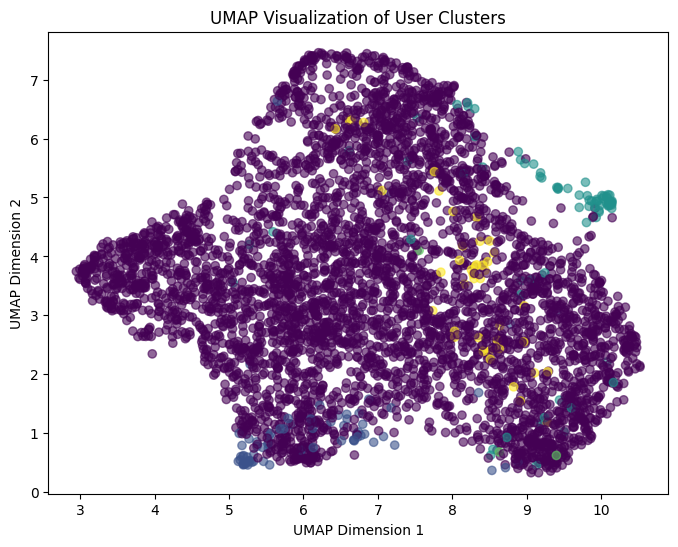

In [ ]:
import umap

# UMAP 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(umap_data[:, 0],umap_data[:, 1],c=labels_agg , alpha=0.6)
plt.title("UMAP Visualization of User Clusters")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

In [ ]:
from sklearn.manifold import trustworthiness

# Trustworthiness Score 계산
score = trustworthiness(jaccard_distance_matrix, umap_data, n_neighbors=5)
print(f"UMAP Trustworthiness Score: {score:.4f}")

UMAP Trustworthiness Score: 0.8462


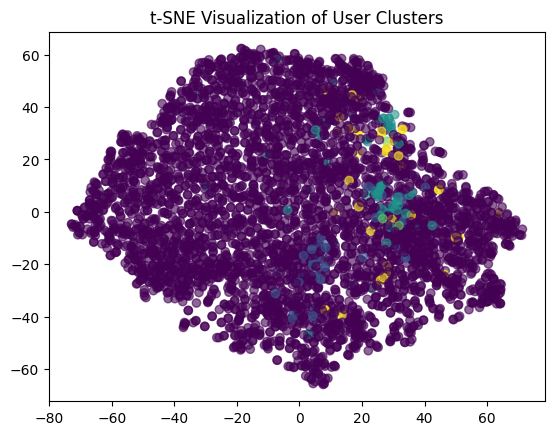

In [ ]:
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], alpha=0.6, c=labels_agg)
plt.title("t-SNE Visualization of User Clusters")
plt.show()

##  **DBSCAN**

In [ ]:
from sklearn.cluster import DBSCAN

# eps, min_samples는 데이터 분포에 따라 적절히 조정 필요
dbscan = DBSCAN(eps=0.5, min_samples=1, metric='precomputed')
labels_dbscan = dbscan.fit_predict(jaccard_distance_matrix)

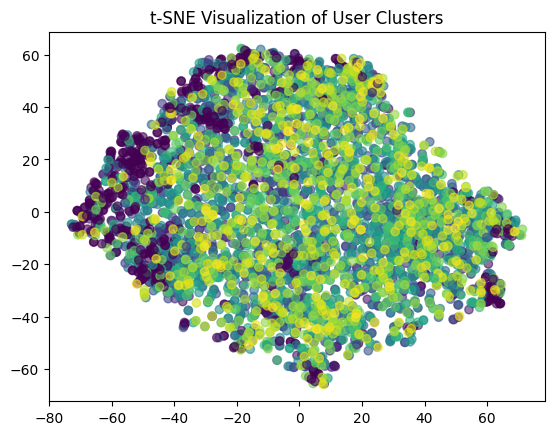

In [ ]:
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], alpha=0.6, c=labels_dbscan)
plt.title("t-SNE Visualization of User Clusters")
plt.show()

In [ ]:
silhouette_score(jaccard_distance_matrix, labels_dbscan, metric="precomputed")

-0.02935865991909139

In [ ]:
data.head()

,user_id,final_recommendations,age,job,male,jac_cluster
0,15,"[527, 1198, 2028, 3578, 153, 110, 85, 750, 134...",25,7,1.0,0
1,17,"[1193, 750, 1198, 904, 541, 608, 1204, 1136, 9...",50,1,1.0,1
2,19,"[1198, 669, 527, 1701, 1580, 372, 150, 2858, 1...",15,10,1.0,0
3,22,"[1089, 1193, 2858, 296, 1136, 1208, 2329, 3421...",18,15,1.0,0
4,33,"[1198, 3578, 2028, 527, 480, 2340, 356, 2940, ...",45,3,1.0,0


In [ ]:
jaccard_distance_matrix.shape

(563, 563)

In [ ]:
!pip install hdbscan
import hdbscan

In [ ]:
hdb= hdbscan.HDBSCAN(min_cluster_size=100)
labels_hdb = hdb.fit_predict(jaccard_distance_matrix)